## **Aplicação de XGBoost Regression**
Neste notebook será aplicado o modelo XGBoost Regression utilizando as features extraídas dos dados.
Para avaliação do desempenho do modelo, serão utilizadas as métricas **MAE**, **MSE**, **RMSE** e **R²**, comparados aos demais modelos testados até agora. 

In [1]:
# confirgurando diretório
import os
os.chdir("..")

import path
path.config()

# importando bibliotecas
import warnings
from tqdm import tqdm
import pandas as pd
from xgboost import XGBRegressor
from main.features import add_features
from main.evaluation import Evaluation
from main.plots import plot_metrics
from main.plots import plot_time_series

# configurando notebook
tqdm.pandas()

warnings.filterwarnings("ignore")

pd.set_option('display.float_format', lambda x: '%.2f' % x)

%load_ext autoreload
%autoreload 2

EVAL_PATH = 'notebooks/data/evaluation.csv'

## **Leitura dos Dados**
Leitura dos dados de treino e teste exportados no notebook *analise_exploratoria.ipynb*. Para cada série, foram separados os 70% primeiros pontos de dados para treino e o restante, ou seja, os dados mais recentes, para teste.

In [2]:
# leitura dos dados
train_df = pd.read_csv("notebooks/data/train_df.csv", parse_dates=['ds'])
test_df = pd.read_csv("notebooks/data/test_df.csv", parse_dates=['ds'])

## **Feature Engineering**

In [3]:
features_train_df = (
    train_df.groupby("unique_id")
    .apply(lambda x: add_features(df=x, df_type='train'))
).reset_index(drop=True)

features_test_df = (
    test_df.groupby("unique_id")
    .apply(lambda x: add_features(df=x, df_type='test'))
).reset_index(drop=True)


In [4]:
features_train_df.columns

Index(['unique_id', 'ds', 'y', 'day', 'month_end', 'feriado', 'day_of_week',
       'week', 'month', 'quarter', 'outlier_min', 'outlier_max'],
      dtype='object')

## **XGBoost Regression**

In [ ]:
def catboost_regressor(df : pd.DataFrame) -> pd.DataFrame:
    """
    Aplicação do modelo XGBoost Regressor.
    """    
    train = df.copy().reset_index(drop=True)
    fcst_df = features_test_df.query(
        "unique_id == @train.unique_id[0]"
    ).reset_index(drop=True)

    train['trend'] = train.index
    fcst_df['trend'] = fcst_df.index + train.index.max() + 1
    
    m = XGBRegressor(
        n_estimators=1000, learning_rate=0.1,
    )
    
    m.fit(
        X=train.iloc[:,3:], y=train.y
    )
    
    fcst_df['y_pred'] = m.predict(fcst_df.iloc[:,3:])

    return fcst_df

In [6]:
# aplicando modelo para cada série
xgb_fcst = features_train_df.groupby("unique_id").apply(catboost_regressor).reset_index(drop=True)

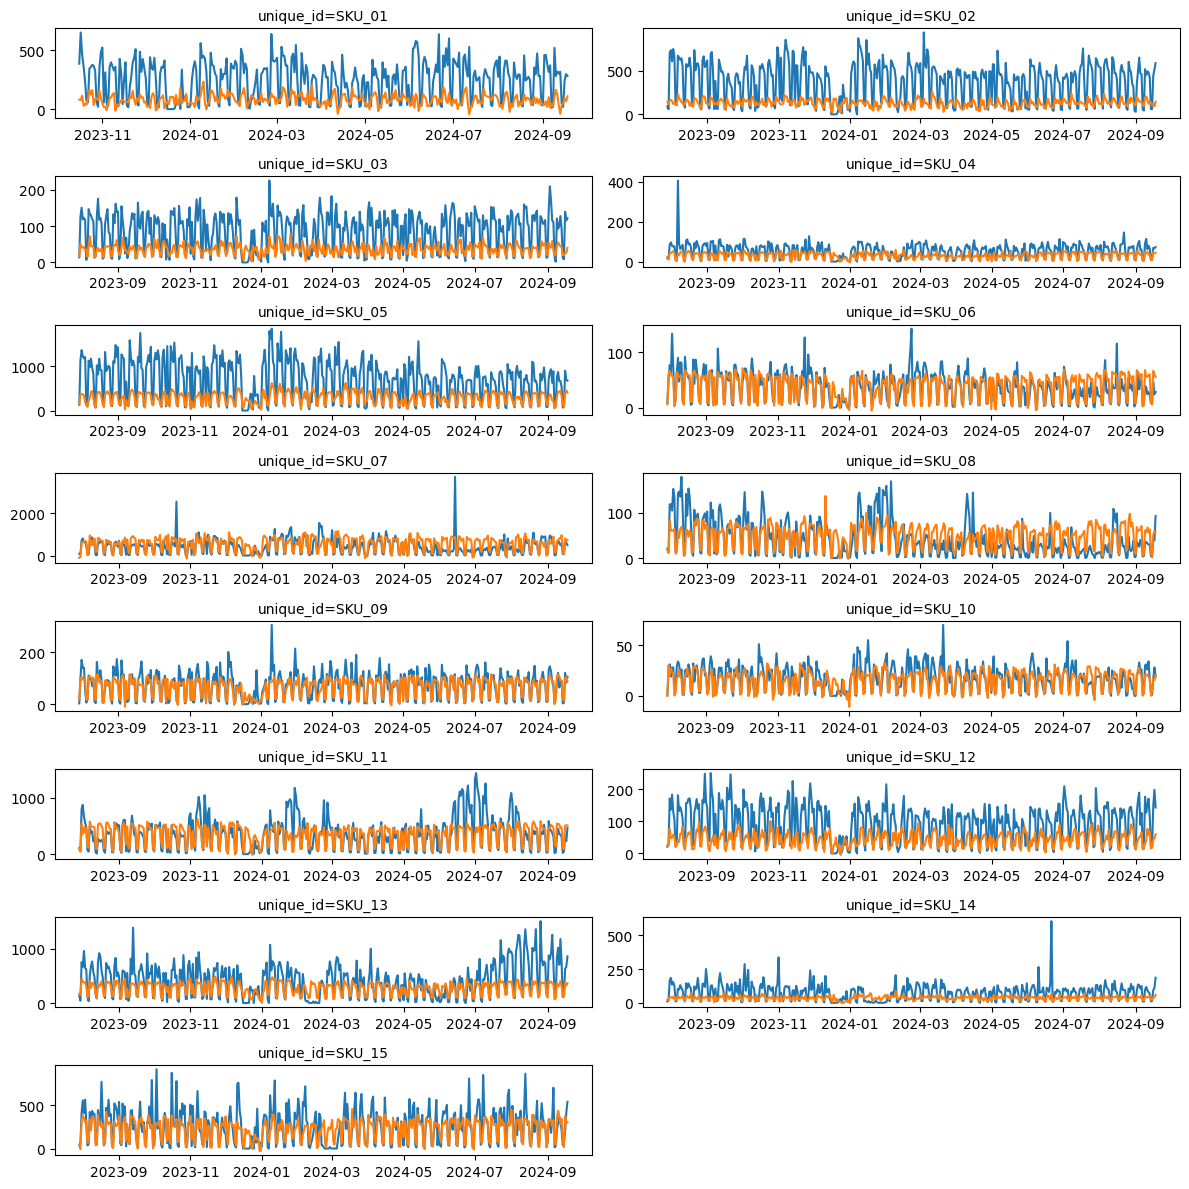

In [7]:
plot_time_series(
    df = xgb_fcst,
    data_cols=['y','y_pred'],
    time_col='ds',
    grid=(8, 2),
    figsize=(12, 12)
)

In [8]:
rf_eval = Evaluation(xgb_fcst)
rf_eval.summary()
rf_eval.save_evaluation(EVAL_PATH, 'XGBoost')
rf_eval.evaluation_df

,mae,mse,rmse,r2
SKU_01,183.88,52420.43,228.96,-0.86
SKU_02,263.19,102968.62,320.89,-0.97
SKU_03,54.09,4405.05,66.37,-0.57
SKU_04,26.09,1384.50,37.21,0.05
SKU_05,423.95,295513.81,543.61,-0.38
SKU_06,12.98,328.49,18.12,0.53
SKU_07,237.10,118012.09,343.53,0.18
SKU_08,26.46,1223.65,34.98,0.27
SKU_09,21.04,988.25,31.44,0.63
SKU_10,6.48,80.50,8.97,0.50


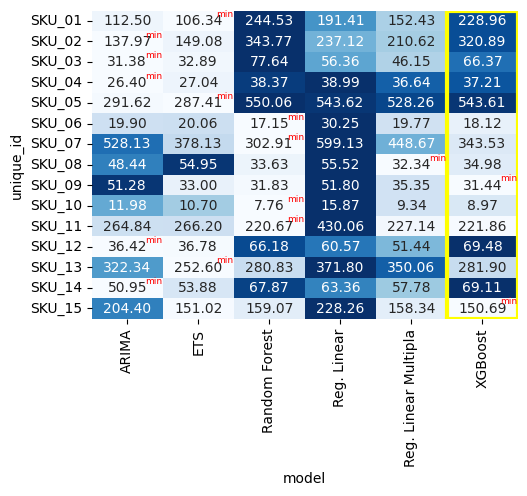

In [12]:
# comparação dos modelos
metrics = pd.read_csv(EVAL_PATH)[['unique_id', 'rmse', 'model']].pivot_table('rmse','unique_id','model')
plot_metrics(metrics, hl_col='XGBoost', figsize=(5.5, 4))